<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b> Итоговый проект. Image2Image
Генерация изображений из других изображений
CGANs</b></h3>



In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm.notebook import tqdm
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import random
import copy
from PIL import Image
from torchvision import transforms
import sys
import os
import torchvision.transforms as transforms

Для реализации базового пайплана будем использовать [классическую](https://arxiv.org/pdf/1703.10593.pdf) архитектуру CGAN и датасет [monet2photo](https://www.kaggle.com/datasets/balraj98/monet2photo)

In [3]:
# constants
# A - Monet, B - real photos
ROOT_DIR = './'
IMG_SIZE = 256
BATCH_SIZE = 2
STATS = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-5
LAMBDA_IDENTITY = 0.5
LAMBDA_CYCLE = 10
NUM_WORKERS = 8
NUM_EPOCHS = 15
LOAD_MODEL = True
SAVE_MODEL = True
WEIGHTS_GEN_A = "genA_weights.tar"
WEIGHTS_GEN_B = "genB_weights.tar"
WEIGHTS_DISC_A = "discA_weights.tar"
WEIGHTS_DISC_B = "discB_weights.tar"
# functions for saving/loading weights in the end/start of each epoch
def save_weights(model, optimizer, filename):
    print(f"SAVING: {filename}")
    weights = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(weights, filename)

def load_weights(weights_file, model, optimizer, lr):
    print(f"LOADING {weights_file}")
    weights = torch.load(weights_file, map_location=DEVICE)
    model.load_state_dict(weights["state_dict"])
    optimizer.load_state_dict(weights["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

def initialize_conv_weights_normal(model):
    classname = model.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(model.weight.data, 0.0, 0.02)
        if hasattr(model, "bias") and model.bias is not None:
            torch.nn.init.constant_(model.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(model.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(model.bias.data, 0.0)

# probably doesn't work(
def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

In [3]:
# dataset class. Be carefull with "endswith('.jpg')" part
class MonetPhotoDataset(Dataset):
    def __init__(self, root_dir=ROOT_DIR, root_A="trainA", root_B="trainB", transform=None):
        self.root_dir = root_dir
        self.root_A = root_A
        self.root_B = root_B
        self.transform = transform
        self.image_files_A = [f for f in os.listdir(os.path.join(root_dir, self.root_A)) if f.endswith('.jpg')]
        self.image_files_B = [f for f in os.listdir(os.path.join(root_dir, self.root_B)) if f.endswith('.jpg')]
        self.monet_length = len(self.image_files_A)
        self.photos_length = len(self.image_files_B)

    def __len__(self):
        return max(self.monet_length, self.photos_length)

    def __getitem__(self, idx):
        img_name_A = os.path.join(self.root_dir, self.root_A, self.image_files_A[idx % len(self.image_files_A)])
        img_name_B = os.path.join(self.root_dir, self.root_B, self.image_files_B[idx % len(self.image_files_B)])
        # idx % len to avoid situation when our idx greater than lenght of dataset. Using this we can cycle our dataset whithin big number of epochs
        
        image_A = Image.open(img_name_A).convert('RGB')
        image_B = Image.open(img_name_B).convert('RGB')

        if self.transform:
            image_A = self.transform(image_A)
            image_B = self.transform(image_B)

        return image_A, image_B

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(*STATS),
])

def denorm(img_tensors):
    return img_tensors * STATS[1][0] + STATS[0][0]

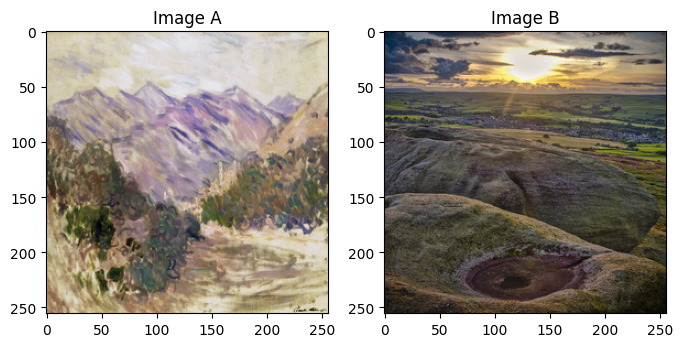

In [4]:
dataset = MonetPhotoDataset(transform=transform, root_A='testA', root_B='testB')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Выводим одну картинку из датасета для теста
for batch in dataloader:
    image_A = denorm(batch[0])
    image_B = denorm(batch[1])

    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(transforms.ToPILImage()(image_A[0]))
    plt.title('Image A')

    plt.subplot(1, 2, 2)
    plt.imshow(transforms.ToPILImage()(image_B[0]))
    plt.title('Image B')

    plt.show()

    break

In [5]:
dataloader

In [6]:
# Discriminator architectures For discriminator networks, we use 70 × 70 PatchGAN [22]. Let Ck denote a
# 4 × 4 Convolution-InstanceNorm-LeakyReLU layer with k
# filters and stride 2. After the last layer, we apply a convolution to produce a 1-dimensional output. We do not use
# InstanceNorm for the first C64 layer. We use leaky ReLUs
# with a slope of 0.2. The discriminator architecture is:
# C64-C128-C256-C512

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.discriminate = nn.Sequential(
            # in: 3 x 256 x 256
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            # We do not use InstanceNorm for the first C64 layer
            nn.LeakyReLU(0.2, inplace=True),
        
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1, padding_mode="reflect"),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"),  
            # out: 1 x 30 x 30
            
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.discriminate(x)
        return x

In [7]:
# Generator architectures We adopt our architectures
# from Johnson et al. [23]. We use 9 residual blocks for 256 × 256 or higher-resolution training images.
# Let c7s1-k denote a 7×7 Convolution-InstanceNormReLU layer with k filters and stride 1. dk denotes a 3 × 3
# Convolution-InstanceNorm-ReLU layer with k filters and
# stride 2. Reflection padding was used to reduce artifacts.
# Rk denotes a residual block that contains two 3 × 3 convolutional layers with the same number of filters on both
# layer. uk denotes a 3 × 3 fractional-strided-ConvolutionInstanceNorm-ReLU layer with k filters and stride 1/2
# The network with 9 residual blocks consists of:
# c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,R256,R256,R256,u128 u64,c7s1-3

# residual block that contains two 3 × 3 convolutional layers with the same number of filters on both layer
class ResidualBlock(nn.Module):
    def __init__(self, filters):
        super().__init__()
        self.connect = nn.Sequential(
            nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1, padding_mode="reflect"),
            nn.InstanceNorm2d(filters),
            nn.ReLU(inplace=True),
            nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1, padding_mode="reflect"),
            nn.InstanceNorm2d(filters),
            nn.Identity()
        )
    def forward(self, x):
        return x + self.connect(x)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # c7s1-k denote a 7×7 Convolution-InstanceNormReLU layer with k filters and stride 1.
        self.first = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
        )
        # dk denotes a 3 × 3 Convolution-InstanceNorm-ReLU layer with k filters and stride 2. Reflection padding
        # d128,d256,
        self.down = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, padding_mode="reflect"),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, padding_mode="reflect"),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),
        )
        
        self.residual = nn.Sequential(
            *[ResidualBlock(256) for _ in range(9)]
        )
        
        # uk denotes a 3 × 3 fractional-strided-ConvolutionInstanceNorm-ReLU layer with k filters and stride 1/2
        self.up = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1,),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
        )

        self.last = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=3, padding_mode="reflect")
        )

    def forward(self, x):
        x = self.first(x)
        x = self.down(x)
        x = self.residual(x)
        x = self.up(x)
        return torch.tanh(self.last(x))

In [8]:
def train_disc(image_A, image_B, disc_A, disc_B, gen_A, gen_B, optimizer):
    optimizer.zero_grad() # nullifying gradients
    # discriminator A train
    fake_A = gen_B(image_B) # generate picture of A domain with second generator from B picture
    disc_A_real_result = disc_A(image_A) # getting result of discriminator for A domain for real(A) picture
    disc_A_fake_result = disc_A(fake_A.detach()) # getting result of discriminator for A domain for fake(A) picture that we generate 2 steps earlier
    mse = nn.MSELoss() # ))))))))))) бля это прикол нахуй так работает а при прямом вызове нет хуле))))00
    ## https://devsolus.com/2022/05/17/mseloss-from-pytorch/
    disc_A_real_loss = mse(disc_A_real_result, torch.ones_like(disc_A_real_result)) # MSE loss for real image 
    disc_A_fake_loss = mse(disc_A_fake_result, torch.zeros_like(disc_A_fake_result)) # MSE loss for fake image
    disc_A_loss = disc_A_fake_loss + disc_A_real_loss # total diacriminator A loss
    # discriminator B train
    fake_B = gen_A(image_A) # generate picture of B domain with first generator from A picture
    disc_B_real_result = disc_B(image_B) # getting result of discriminator for B domain for real(B) picture
    disc_B_fake_result = disc_B(fake_B.detach()) # getting result of discriminator for B domain for fake(B) picture that we generate 2 steps earlier
    disc_B_real_loss = mse(disc_B_real_result, torch.ones_like(disc_B_real_result)) # MSE loss for real image (second domain)
    disc_B_fake_loss = mse(disc_B_fake_result, torch.zeros_like(disc_B_fake_result)) # MSE loss for fake image (second domain)
    disc_B_loss = disc_B_fake_loss + disc_B_real_loss # total diacriminator B loss

    disc_loss = disc_A_loss + disc_B_loss # total discriminators loss
    disc_loss.backward() # calculate gradients 
    optimizer.step() # make step
    
    return fake_A, fake_B, disc_loss.item()

In [9]:
def train_generator(image_A, image_B, fake_A, fake_B, disc_A, disc_B, gen_A, gen_B, optimizer):
    optimizer.zero_grad() # nullifying gradients
    # adversarial losses   
    discriminator_A_fake = disc_A(fake_A)
    discriminator_B_fake = disc_A(fake_B)
    mse = nn.MSELoss()
    generator_A_loss = mse(discriminator_A_fake, torch.ones_like(discriminator_A_fake))
    generator_B_loss = mse(discriminator_B_fake, torch.ones_like(discriminator_B_fake))
    # cycle loss
    cycle_A = gen_A(fake_B)
    cycle_B = gen_B(fake_A)
    Lloss = nn.L1Loss()
    cycle_A_loss = Lloss(image_A, cycle_A)
    cycle_B_loss = Lloss(image_B, cycle_B)
    # identity loss 
    identity_A = gen_A(image_A)
    identity_B = gen_B(image_B)
    identity_A_loss = Lloss(image_A, identity_A)
    identity_B_loss = Lloss(image_B, identity_B)
    # total generator loss
    gen_loss = (generator_A_loss + generator_B_loss + (cycle_A_loss + cycle_B_loss) * LAMBDA_CYCLE + (identity_A_loss + identity_B_loss) * LAMBDA_IDENTITY)
    gen_loss.backward()
    optimizer.step()
    
    return gen_loss.item()


In [11]:
def fit():
    torch.cuda.empty_cache() # idk does it help. added just in case
    # create generator instances
    generator_A = Generator().to(DEVICE) 
    generator_B = Generator().to(DEVICE)
    # create discrminator instances
    discriminator_A = Discriminator().to(DEVICE) 
    discriminator_B = Discriminator().to(DEVICE)
    # create optimizators for gen/disc
    disc_opt = optim.Adam(list(discriminator_A.parameters()) + list(discriminator_B.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999))
    gen_opt = optim.Adam(list(generator_A.parameters()) + list(generator_B.parameters()),
        lr=LEARNING_RATE,
        betas=(0.5, 0.999))
    # if we already have weights for our gens and discs we load them. Otherwise we initialize them with normal distribution instead of random
    if LOAD_MODEL:
        load_weights(WEIGHTS_GEN_A, generator_A, gen_opt, LEARNING_RATE)
        load_weights(WEIGHTS_GEN_B, generator_B, gen_opt, LEARNING_RATE)
        load_weights(WEIGHTS_DISC_A, discriminator_A, disc_opt, LEARNING_RATE)
        load_weights(WEIGHTS_DISC_B, discriminator_B, disc_opt, LEARNING_RATE)
    else:
        initialize_conv_weights_normal(generator_A)
        initialize_conv_weights_normal(generator_B)
        initialize_conv_weights_normal(discriminator_A)
        initialize_conv_weights_normal(discriminator_B)
    # create datasets/dataloaders. test part is redundant but i keep it there 
    Train_dataset = MonetPhotoDataset(transform=transform, root_A='trainA', root_B='trainB')
    Train_dataloader = DataLoader(Train_dataset, batch_size=1, shuffle=True, pin_memory=True)
    Test_dataset = MonetPhotoDataset(transform=transform, root_A='testA', root_B='testB')
    Test_dataloader = DataLoader(Test_dataset, batch_size=1, shuffle=True, pin_memory=True)
    # lists to save losses
    disc_loss_list = []
    gen_loss_list = []
    
    for epoch in range(NUM_EPOCHS):
        for idx, (image_A, image_B) in enumerate(tqdm(Train_dataloader)):
            image_A = image_A.to(DEVICE)
            image_B = image_B.to(DEVICE)
            fake_A, fake_B, disc_loss = train_disc(image_A, image_B, discriminator_A, discriminator_B, generator_A, generator_B, disc_opt)
            disc_loss_list.append(disc_loss)
            gen_loss = train_generator(image_A, image_B, fake_A, fake_B, discriminator_A, discriminator_B, generator_A, generator_B, gen_opt)
            gen_loss_list.append(gen_loss)
            if idx % 1000 == 0:
                save_image(denorm(fake_A), f"saved_images/p2m_epoch_{epoch+1}_{idx}.png")
                save_image(denorm(fake_B), f"saved_images/m2p_epoch_{epoch+1}_{idx}.png") 

        if SAVE_MODEL:
            save_weights(generator_A, gen_opt, filename=WEIGHTS_GEN_A)
            save_weights(generator_B, gen_opt, filename=WEIGHTS_GEN_B)
            save_weights(discriminator_A, disc_opt, filename=WEIGHTS_DISC_A)
            save_weights(discriminator_B, disc_opt, filename=WEIGHTS_DISC_B)
    
    return disc_loss_list, gen_loss_list

In [35]:
d_loss, g_loss = fit()

LOADING genA_weights.tar
LOADING genB_weights.tar
LOADING discA_weights.tar
LOADING discB_weights.tar


  0%|          | 0/6287 [00:00<?, ?it/s]

SAVING: genA_weights.tar
SAVING: genB_weights.tar
SAVING: discA_weights.tar
SAVING: discB_weights.tar


  0%|          | 0/6287 [00:00<?, ?it/s]

SAVING: genA_weights.tar
SAVING: genB_weights.tar
SAVING: discA_weights.tar
SAVING: discB_weights.tar


  0%|          | 0/6287 [00:00<?, ?it/s]

SAVING: genA_weights.tar
SAVING: genB_weights.tar
SAVING: discA_weights.tar
SAVING: discB_weights.tar


  0%|          | 0/6287 [00:00<?, ?it/s]

SAVING: genA_weights.tar
SAVING: genB_weights.tar
SAVING: discA_weights.tar
SAVING: discB_weights.tar


  0%|          | 0/6287 [00:00<?, ?it/s]

SAVING: genA_weights.tar
SAVING: genB_weights.tar
SAVING: discA_weights.tar
SAVING: discB_weights.tar


  0%|          | 0/6287 [00:00<?, ?it/s]

SAVING: genA_weights.tar
SAVING: genB_weights.tar
SAVING: discA_weights.tar
SAVING: discB_weights.tar


  0%|          | 0/6287 [00:00<?, ?it/s]

SAVING: genA_weights.tar
SAVING: genB_weights.tar
SAVING: discA_weights.tar
SAVING: discB_weights.tar


  0%|          | 0/6287 [00:00<?, ?it/s]

SAVING: genA_weights.tar
SAVING: genB_weights.tar
SAVING: discA_weights.tar
SAVING: discB_weights.tar


  0%|          | 0/6287 [00:00<?, ?it/s]

SAVING: genA_weights.tar
SAVING: genB_weights.tar
SAVING: discA_weights.tar
SAVING: discB_weights.tar


  0%|          | 0/6287 [00:00<?, ?it/s]

SAVING: genA_weights.tar
SAVING: genB_weights.tar
SAVING: discA_weights.tar
SAVING: discB_weights.tar


  0%|          | 0/6287 [00:00<?, ?it/s]

SAVING: genA_weights.tar
SAVING: genB_weights.tar
SAVING: discA_weights.tar
SAVING: discB_weights.tar


  0%|          | 0/6287 [00:00<?, ?it/s]

SAVING: genA_weights.tar
SAVING: genB_weights.tar
SAVING: discA_weights.tar
SAVING: discB_weights.tar


  0%|          | 0/6287 [00:00<?, ?it/s]

SAVING: genA_weights.tar
SAVING: genB_weights.tar
SAVING: discA_weights.tar
SAVING: discB_weights.tar


  0%|          | 0/6287 [00:00<?, ?it/s]

SAVING: genA_weights.tar
SAVING: genB_weights.tar
SAVING: discA_weights.tar
SAVING: discB_weights.tar


  0%|          | 0/6287 [00:00<?, ?it/s]

SAVING: genA_weights.tar
SAVING: genB_weights.tar
SAVING: discA_weights.tar
SAVING: discB_weights.tar


<h3 style="text-align: center;"><b>ИТОГ</b></h3>


1. В процессе обучения была допущена ошибка которая привела к потере весов и графиков потерь. Тем не менее результаты обучения на ~60 эпохах удовлетворительные (примеры ниже). В связи с отсутствием времени (эпоха со стандартной точностью и на ~6к изображений занимала на моем компьютере ~1.5 часа, что при 200 эпохах из статьи заняло бы 300 часов или чуть менее двух недель реального времени). Было принято решение перейти к экспериментам с архитекторуй/парметрами модели и новому датасету.
2. Часть параметров захардкожена (например количество фичей в дискрименаторе/генераторе), что может быть легко исправлено, но временного лимита как и лимита силы воли уже не хватает. Так же можно было снизить точность вычислений до fp16, что вроде как не привело бы к заметному снижению качества, но сильно ускорило бы процесс обучения. А так же миллион других вещей типа добавление инференса в бейзлайн по тесту, но имеем что имеем 
3. Некоторые вещи/идеи подсмотрены [отсюда](https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs/CycleGAN) что-то по мелочи даже скопиравно типа seed_everything, но я до конца не уверен насколько конкретно эта функция сработала вообще.
4. Для финальной "продактовой" реализации были использованы датасеты [спаршенных с данбору женских персонажей](https://drive.google.com/file/d/13C7Jphi8dYkY_0HoqIZeXAIkppyKlzmQ/view) и [CelebaVask-HQ](https://drive.google.com/file/d/1wwKrufFxZjhTDDm-eHD6Ent2Kc-gOHs7/view). Они были вручную зарезаны до 1900 экземпляров, чтобы успеть обучить хоть что-то. В более свежих статьях показывается, что классический CycleGAN без доп примочек слабо справляется с конкретно такой задачей если не заниматься черрипикингом (так даже у меня получилось некоторое количество удобоваримых результатов) [пример на стр.15](https://arxiv.org/abs/1907.10830). Тогда зачем я взялся за этот датасет? Ну я почти день искал что-то не заезженное. Понял, что теряю время в никуда и взял это не надеясь на хороший результат, зато теперь есть мотивация покывыряться с attention map и прочим.
5. Отличия от бейзлайна в версии для бота: датасет, LAMBDA_IDENTITY и 
LAMBDA_CYCL снижены, количество рес блоков увеличено до 14, в ручную снижался LR каждые 30-50 эпох на 10-20% от 3Е-4 до 2Е-5 (смысла делать динамический LR или шелдурер не увидел, всё равно учил по 30-50 упох пока спал/был на работе), убрана загрузка тестового датасета и соответственно создание даталоадера (это, кстати следовало сделать и бейзлайне, дало неплохой прирост итераций в секунду), убраны некоторые лишние детали типа колекционирования значений лоссов, добален инференс и прочие штуки для работы бота.8

# Пример недообученного фото в Моне
<img src="https://sun9-46.userapi.com/impf/DXezemfOLXj6Te0ClwpIxbkCPsOZ9Ov0GpiGmw/RLzUB5OI2ao.jpg?size=256x256&quality=96&sign=fd3a9639beb22394888b47196d5e424e&type=album">

# Пример недообученного Моне в Фото
<img src="https://sun9-66.userapi.com/impf/UDpV7frDx4Zv62cRg0vkxXx290W_WRodsiI4xg/aXEZ33D-mxs.jpg?size=256x256&quality=96&sign=d8ff58a0a1238b1f5825177f0034b4cb&type=album">

P.S. Я после того как всё таки расправился с генератором...

<img src="https://sun9-54.userapi.com/impf/vMktr0PNGh7hvx7Ji942hDvD5oKkrS48ax_4Hg/UWabOtOWsI4.jpg?size=828x491&quality=95&sign=2ef8eaccdc6c49b692b5eda623aacc50&type=album">